In [9]:
%matplotlib inline

In [15]:
from GLOBALS import FULL_DATASET_PATH
from plot_heatmap import build_pivot
import pandas as pd

data = pd.read_csv(FULL_DATASET_PATH, index_col="id_site", encoding="windows-1252")

data["cf_vs_broadleaved_forests"] = 1 - data["otu_richness"] / data.loc[data["land_use"] == "broadleaved forests", "otu_richness"].median()
pivot_median = build_pivot(data=data,
                    value_field="otu_richness",
                    line_field="land_use",
                    col_field="bioregion",
                    top_n=10,
                    func='median')

pivot_count = build_pivot(data=data,
                    value_field="otu_richness",
                    line_field="land_use",
                    col_field="bioregion",
                    top_n=10,
                    func='count')

In [4]:
pivot_count

bioregion,Alpine,Atlantic,Continental,Mediterranean
land_use,,,,
annual crops,2.0,504.0,190.0,41.0
broadleaved forests,12.0,124.0,105.0,36.0
coniferous forests,27.0,64.0,90.0,42.0
meadows,31.0,160.0,233.0,37.0
natural sites,28.0,4.0,5.0,16.0
permanent crops,NaN,16.0,8.0,22.0
urban sites,NaN,8.0,1.0,11.0


In [14]:
#calculate CF for each land use and each bioregion as 1 - (median of land_use and bioregion) / (median of broadleaved forests in the same bioregion))
cf_df = 1 - pivot_median / pivot_median.loc['broadleaved forests']
cf_df

bioregion,Alpine,Atlantic,Continental,Mediterranean
land_use,,,,
annual crops,-0.131267,-0.126506,-0.084012,-0.043519
broadleaved forests,0.000000,0.000000,0.000000,0.000000
coniferous forests,0.054695,0.158384,0.105143,0.008042
meadows,0.029170,-0.096135,-0.100305,0.009934
natural sites,0.073382,-0.000753,0.050916,-0.077342
permanent crops,NaN,-0.018825,-0.082994,-0.133869
urban sites,NaN,-0.279618,-0.002037,-0.044939


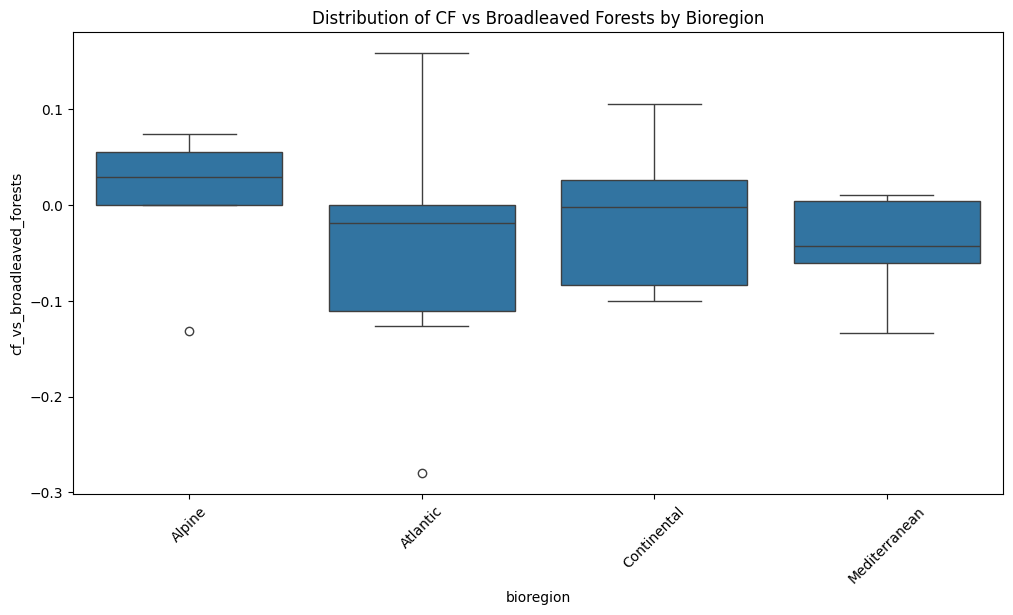

In [16]:
#plot distribution of cf_vs_broadleaved_forests values
import seaborn as sns
import matplotlib.pyplot as plt
cf_melted = cf_df.reset_index().melt(id_vars="land_use", var_name="bioregion", value_name="cf_vs_broadleaved_forests")
plt.figure(figsize=(12, 6))
sns.boxplot(data=cf_melted, x="bioregion", y="cf_vs_broadleaved_forests")
plt.xticks(rotation=45)
plt.title("Distribution of CF vs Broadleaved Forests by Bioregion")
plt.show()


AttributeError: 'AxesImage' object has no attribute 'set_legend'

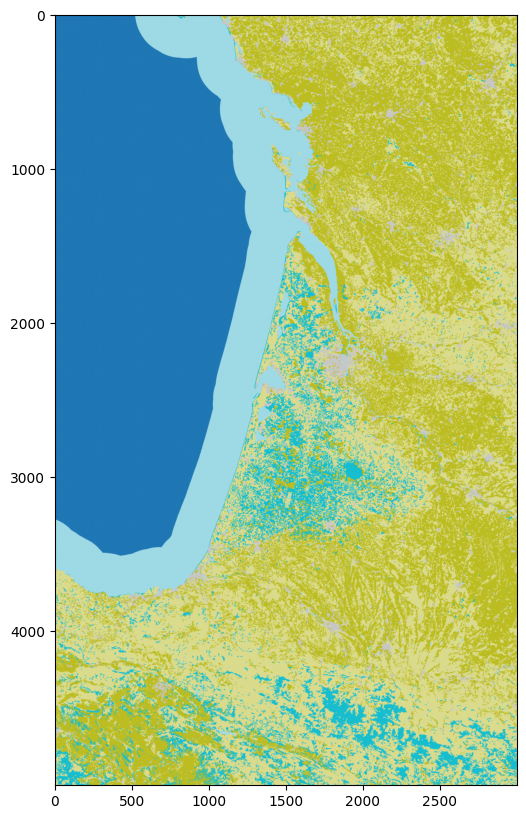

In [ ]:
from GLOBALS import CORINE_PATH, FRANCE_BOX_EPSG_2154
import rasterio
import matplotlib.pyplot as plt
from plot_map import generate_rmqs_geodataframe


corine = rasterio.open(CORINE_PATH)
corine_window = corine.read(1, window=rasterio.windows.from_bounds(*(3.3e6, 2.2e6 , 3.6e6, 2.7e6), transform=corine.transform))

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(corine_window, cmap='tab20')
plt.show()